In [1]:
# Install for running in colab
!pip install biopython fair-esm &> /dev/null

# Zero-shot prediction of functional protein sequence variants

In Moderna Therapeutics's study titled ["Therapeutic Enzyme Engineering Using a Generative Neural Network"](https://www.nature.com/articles/s41598-022-05195-x), scientists turbocharge ornithine transcarbamylase (OTC), a critical player in the urea cycle combating a rare metabolic ailment. Their secret sauce? Marrying insights from nature's evolution dance with a dash of artificial evolution guided by savvy deep learning models. Meanwhile, in the paper ["Efficient evolution of human antibodies from general protein language models"](https://www.nature.com/articles/s41587-023-01763-2), authors play protein origami, deftly evolving human antibodies sans the cheat sheet on target antigen specifics binding specificity, or protein structure. No experimental data for model supervision; both approaches propose beneficial mutations in a zero-shot manner.

Crafting functional protein sequences in the protein engineering arena is a puzzle akin to navigating a vast cosmic expanse. Picture a protein with 200 amino acids; a mere switcheroo of one amino acid spawns a array of 4000 potential variants (200*20). My [previous notebooks](https://nbviewer.org/github/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq_to_fxn_model.ipynb) used machine learning as the Sherpa guiding directed evolution when armed with experimental compass. But what if the experimental compass is missing? Can we still map out a path to promising protein sequences by divining the protein's mutational horoscope?

Nature leaves us clues, imprinting functional wisdom in protein sequences. Enter the unsupervised models, revealing higher functional variant tales from the sequence data troves, as showcased in the article ["Language models enable zero-shot prediction of the effects of mutations on protein function"](https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2). These unsupervised maestros for predicting protein variant effects fall into three troupes: **hybrid protein language models (PLMs)**, **PLMs**, and **alignment based models**.

Our playbook? This notebook orchestrates and contrasts these model from each class, aiming to spotlight protein sequence gems that can lighten the load of experimental quests in directed evolution. The playbook uses competitive models from the benchmarks set by ProteinGym](https://proteingym.org/), providing a comprehensive evaluation of these models' capabilities in predicting the mutational landscape of proteins.

**Goals**
- Efficiently identify promising protein sequence variants to alleviate the experimental screening burden in directed evolution.
- Provide a canvas of mutational landscape, specifically focusing on the [encapsidation protein 22K crucial for recombinant Adeno-Associated Virus (rAAV) production](https://pubmed.ncbi.nlm.nih.gov/38062776/). Maybe there are protein sequence gems that hold the key to improving rAAV production?

## Protein fitness landscape prediction using Hybrid PLMs

- Large Protein Language Models (PLMs) are trained on large protein databases encompassing all known sequences or on sets of homologous sequences spanning many protein families.
- Hybrid PLMs are PLMs that leverage multiple sequence alignment (MSAs)  such as [Tranception](https://arxiv.org/abs/2205.13760), and [MSA Transformer](https://www.biorxiv.org/content/10.1101/2021.02.12.430858v1.full).
- Below is the take on hybrid PLMs from [Pascal Notin](https://twitter.com/NotinPascal) author of [ProteinGym](https://proteingym.org/benchmarks) paper.

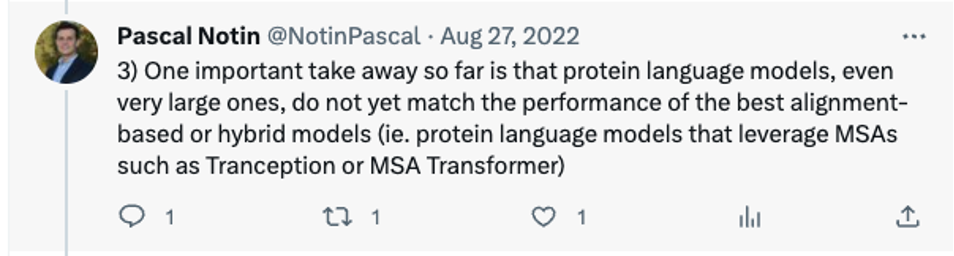

From the hybrid PLMs class, we will be using [MSA Transformer](https://www.biorxiv.org/content/10.1101/2021.02.12.430858v1.full) to predict mutational landscape for encapsidation protein 22K.

### Obtain FASTA file of protein sequence

In [2]:
query_url =  "https://rest.uniprot.org/uniprotkb/A0A7L4WH77.fasta"

In [3]:
import requests
from Bio import SeqIO
from io import StringIO

def read_fasta_from_url(url):
    # Download the FASTA file content from the web link
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the content using Biopython's SeqIO
        fasta_content = StringIO(response.text)
        record = next(SeqIO.parse(fasta_content, 'fasta'))
        sequence = str(record.seq)

        return sequence
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")

In [4]:
protein_sequence = read_fasta_from_url(query_url)
print(f"Protein Sequence: {protein_sequence}")
print(f"Protein Sequence Length: {len(protein_sequence)}")

Protein Sequence: MAPKKKLQLPPPPTDEEEYWDSQAEEVLDEEEEEDMMEDWESLDEEASEAEEVSDETPSPSVAFPSPAPQKSATGSSMATTSAPQASPALPVRRPNRRWDTTGTRAGKSKQPPPLAQEQQQRQGYRSWRGHKNAIVACLQDCGGNISFARRFLLYHHGVAFPRNILHYYRHLYSPYCTGGSSSNSSGHTEAKATG
Protein Sequence Length: 195


In [5]:
# Save FASTA file locally for future reference
# The -O option in wget allows you to specify the name of the output file.
!wget $query_url -O data/Encapsidation_protein_22K.fasta

--2023-12-15 22:05:41--  https://rest.uniprot.org/uniprotkb/A0A7L4WH77.fasta
Resolving rest.uniprot.org (rest.uniprot.org)... 193.62.193.81
Connecting to rest.uniprot.org (rest.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309 [text/plain]
Saving to: ‘data/Encapsidation_protein_22K.fasta’

data/Encapsidation_ 100%[===================>]     309  --.-KB/s    in 0s      

2023-12-15 22:05:42 (178 MB/s) - ‘data/Encapsidation_protein_22K.fasta’ saved [309/309]



### Generate sequence alignment in a3m format

The sequence alignment for encapsidation protein 22K was generated using [MMSeq2](https://github.com/soedinglab/MMseqs2) from [ColabFold v1.5.3 server](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=kOblAo-xetgx).

In [6]:
# Number of entries in the MSA file
!grep -c "^>" data/Encapsidation_protein_22K.a3m

124


In [7]:
!head -n 9 data/Encapsidation_protein_22K.a3m

#195	1
>101
MAPKKKLQLPPPPTDEEEYWDSQAEEVLDEEEEEDMMEDWESLDEEASEAEEVSDETPSPSVAFPSPAPQKSATGSSMATTSAPQASPALPVRRPNRRWDTTGTRAGKSKQPPPLAQEQQQRQGYRSWRGHKNAIVACLQDCGGNISFARRFLLYHHGVAFPRNILHYYRHLYSPYCTGGSSSNSSGHTEAKATG
>UniRef100_A0A7L4WJM1	270	0.923	1.137E-78	0	194	195	0	193	194
MAPKKKLQLP-PPPTDEEEYWDSQAEEVLDEEEEDMMEDWESLDEEASEAEEVSDETPSPSVAFPSPAPQKSATGSSMATTSAPQASPALPVRRPNRRWDTTGTRAGKSKQPPPLAQEQQQRQGYRSWRGHKNAIVACLQDCGGNISFARRFLLYHHGVAFPRNILHYYRHLYSPYCTGGSSSNSSGHTEAKATG
>UniRef100_A0A3Q9HLG8	259	0.892	7.754E-75	0	194	195	0	193	194
MAPKKKLQLP-PPPTDEEEYWDSQAEEVLDEEEEDMMEDWESLDEEASEAEEVSDGTPSPSVASPSPAPQKSATGPSMATTSAPQAPPALPVRRPNRRWDTTGTRAGKSKQPPPLAQEQQQRQGYRSWRGHKNAIVACLQDCGGNISFARRFLLYHHGVAFPRNILHYYRHLYSPYCTGGSGSNSSGHTEAKAPG
>UniRef100_A0A3Q9HL92	258	0.888	1.457E-74	0	194	195	0	196	197
MAPKKKLQLPPPPPTDEEEYWDSQAEEVLDEEEEDTMEDWDSLDEEASEAEEVSDETPSPSVAFPSPAPQKSATGPSMATTSAPQAPPALPVRRPNRRWDTTGTRAGKSKQPPPLAQEQQQRQGYRSWRGHKNAIVACLQDCGGNISFARRFLLYHHGVAFPRNILHYYRHLYSPYYTGgsGSGSNSSGHTEAKATG


### Generate mutant triplets to make predictions

In [8]:
def generate_mutant_triplet(protein_sequence):

    '''
    Input:
    protein_sequence: the input protein sequence for which you want to generate mutant triplets.

    Output:
    This script will generate all possible mutant triplets for the input protein sequence.
    '''

    # Define the amino acid alphabet (one-letter codes)
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"

    # Create a list to store the mutant sequences
    mutants = []

    # Iterate through each position in the protein sequence
    for position in range(len(protein_sequence)):

        # Generate mutants for each amino acid in the alphabet
        for aa in amino_acids:
            # Create a mutant sequence by replacing the original amino acid
            mutant = protein_sequence[position] + str(position+1) + aa
            mutants.append(mutant)

    # Print the list of mutant sequences
    return mutants

In [9]:
mutant = generate_mutant_triplet(protein_sequence)
print(mutant)

['M1A', 'M1C', 'M1D', 'M1E', 'M1F', 'M1G', 'M1H', 'M1I', 'M1K', 'M1L', 'M1M', 'M1N', 'M1P', 'M1Q', 'M1R', 'M1S', 'M1T', 'M1V', 'M1W', 'M1Y', 'A2A', 'A2C', 'A2D', 'A2E', 'A2F', 'A2G', 'A2H', 'A2I', 'A2K', 'A2L', 'A2M', 'A2N', 'A2P', 'A2Q', 'A2R', 'A2S', 'A2T', 'A2V', 'A2W', 'A2Y', 'P3A', 'P3C', 'P3D', 'P3E', 'P3F', 'P3G', 'P3H', 'P3I', 'P3K', 'P3L', 'P3M', 'P3N', 'P3P', 'P3Q', 'P3R', 'P3S', 'P3T', 'P3V', 'P3W', 'P3Y', 'K4A', 'K4C', 'K4D', 'K4E', 'K4F', 'K4G', 'K4H', 'K4I', 'K4K', 'K4L', 'K4M', 'K4N', 'K4P', 'K4Q', 'K4R', 'K4S', 'K4T', 'K4V', 'K4W', 'K4Y', 'K5A', 'K5C', 'K5D', 'K5E', 'K5F', 'K5G', 'K5H', 'K5I', 'K5K', 'K5L', 'K5M', 'K5N', 'K5P', 'K5Q', 'K5R', 'K5S', 'K5T', 'K5V', 'K5W', 'K5Y', 'K6A', 'K6C', 'K6D', 'K6E', 'K6F', 'K6G', 'K6H', 'K6I', 'K6K', 'K6L', 'K6M', 'K6N', 'K6P', 'K6Q', 'K6R', 'K6S', 'K6T', 'K6V', 'K6W', 'K6Y', 'L7A', 'L7C', 'L7D', 'L7E', 'L7F', 'L7G', 'L7H', 'L7I', 'L7K', 'L7L', 'L7M', 'L7N', 'L7P', 'L7Q', 'L7R', 'L7S', 'L7T', 'L7V', 'L7W', 'L7Y', 'Q8A', 'Q8C', 'Q8D'

In [10]:
import pandas as pd

Encapsidation_protein_22K_mutants_df = pd.DataFrame({
    "mutant": mutant
})

Encapsidation_protein_22K_mutants_df['wildtype'] = Encapsidation_protein_22K_mutants_df['mutant'].str[:-1]
Encapsidation_protein_22K_mutants_df['mutation'] = Encapsidation_protein_22K_mutants_df['mutant'].str[-1]

Encapsidation_protein_22K_mutants_df.to_csv('data/Encapsidation_protein_22K_mutants_unlabeled.csv', index=False)

### Predict fitness landscape

In [11]:
# We meed the MSA file in .a3m format and csv file with mutant triplet to run the script below
!ls data/

Encapsidation_protein_22K.a3m	 Encapsidation_protein_22K_mutants_unlabeled.csv
Encapsidation_protein_22K.fasta


In [12]:
# Script to generate mutational landscape
# predict_esm.py script from: https://github.com/facebookresearch/esm/blob/main/examples/variant-prediction/predict.py

!python scripts/predict_esm.py \
    --model-location esm_msa1b_t12_100M_UR50S \
    --sequence $protein_sequence \
    --dms-input ./data/Encapsidation_protein_22K_mutants_unlabeled.csv \
    --mutation-col mutant \
    --dms-output ./data/Encapsidation_protein_22K_mutants_labeled.csv \
    --offset-idx 1 \
    --scoring-strategy masked-marginals \
    --msa-path ./data/Encapsidation_protein_22K.a3m

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S-contact-regression.pt
Transferred model to GPU
100% 196/196 [01:46<00:00,  1.83it/s]


### Visualize fitness landscape

In [13]:
import pandas as pd

# Read the csv file containing mutation score from MSA Transformer model
fitness_prot22k_msa1b = pd.read_csv('data/Encapsidation_protein_22K_mutants_labeled.csv',
                                    index_col=0)
fitness_prot22k_msa1b

,mutant,wildtype,mutation,esm_msa1b_t12_100M_UR50S
0,M1A,M1,A,-16.325127
1,M1C,M1,C,-16.986792
2,M1D,M1,D,-18.815874
3,M1E,M1,E,-17.576103
4,M1F,M1,F,-13.433237
...,...,...,...,...
3895,G195S,G195,S,-9.930399
3896,G195T,G195,T,-13.784996
3897,G195V,G195,V,-12.468152
3898,G195W,G195,W,-14.053451


In [14]:
# Long to wide format conversion for plotting heatmap
fitness_prot22k_msa1b_wide = fitness_prot22k_msa1b.pivot_table(index='mutation',
                                                               columns='wildtype',
                                                               values='esm_msa1b_t12_100M_UR50S',
                                                               sort=False)

In [16]:
import plotly.graph_objects as go

def create_heatmap(values, title='Predicted mutation effects'):

    # Put 0 as midpoint for divergent colorscale
    midpoint = (0 - values.min().min())/(values.max().max() - values.min().min())

    # Define custom colorscale for blue (negative) to red (positive)
    custom_colorscale = [[0, "rgb(0.03137254901960784, 0.18823529411764706, 0.4196078431372549)"],
                         [midpoint, 'white'],
                         [1, 'red']]

    # Create heatmap trace
    heatmap_trace = go.Heatmap(
        x=values.columns,
        y=values.index,
        z=values,
        colorscale=custom_colorscale
    )

    # Create layout with equal aspect ratio
    layout = go.Layout(
        title=title,
        xaxis=dict(title='wildtype'),
        yaxis=dict(title='mutation', autorange='reversed')
    )

    # Create figure
    heatmap_figure = go.Figure(data=[heatmap_trace], layout=layout)

    # Show the plot
    heatmap_figure.show()

In [17]:
create_heatmap(fitness_prot22k_msa1b_wide,
               title='Predicted mutation effects using esm_msa1b_t12_100M_UR50S')

Heatmap which shows us hotspots for mutations that are beneficial or detrimental to the function of the protein.

## Protein fitness landscape prediction using PLMs

- Protein Language Models (PLMs) are LLMs trained on large protein databases encompassing all known sequences such as [VESPA](https://link.springer.com/article/10.1007/s00439-021-02411-y), [ESM2](https://github.com/facebookresearch/esm#esmfold), and [ESM1v](https://github.com/facebookresearch/esm#zs_variant).

- PLMs adeptly learn evolutionary constraints that generalize across protein families.

- PLM both bidirectional and autoregressive generative models particularly excel in scenarios involving small families with sparse homologs. However, they generally underperform family-specific models for larger families.

We will be using [ESM2](https://github.com/facebookresearch/esm#esmfold), and [ESM1v](https://github.com/facebookresearch/esm#zs_variant) to predict mutational landscape for encapsidation protein 22K.

### Predict fitness landscape

In [18]:
# Script to generate mutational landscape
# predict_esm.py script from: https://github.com/facebookresearch/esm/blob/main/examples/variant-prediction/predict.py

!python scripts/predict_esm.py \
    --model-location esm2_t33_650M_UR50D esm1v_t33_650M_UR90S_1 esm1v_t33_650M_UR90S_2 esm1v_t33_650M_UR90S_3 esm1v_t33_650M_UR90S_4 esm1v_t33_650M_UR90S_5 esm1b_t33_650M_UR50S \
    --sequence $protein_sequence \
    --dms-input ./data/Encapsidation_protein_22K_mutants_labeled.csv \
    --mutation-col mutant \
    --dms-output ./data/Encapsidation_protein_22K_mutants_labeled.csv \
    --offset-idx 1 \
    --scoring-strategy masked-marginals

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Transferred model to GPU
100% 197/197 [00:07<00:00, 27.64it/s]
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1v_t33_650M_UR90S_1.pt" to /root/.cache/torch/hub/checkpoints/esm1v_t33_650M_UR90S_1.pt
/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Transferred model to GPU
100% 197/197 [00:06<00:00, 32.13it/s]
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1v_t33_650M_UR90S_2.pt" to /root/.cache/torch/hub/checkpoints/esm1v_t33_650M_UR90S_2.pt
/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:2

### Visualize fitness landscape

In [19]:
# Read the csv file containing mutation score from ESM models
fitness_prot22k_esm = pd.read_csv('data/Encapsidation_protein_22K_mutants_labeled.csv',
                                    index_col=0)
fitness_prot22k_esm

,Unnamed: 0,mutant,wildtype,mutation,esm_msa1b_t12_100M_UR50S,esm2_t33_650M_UR50D,esm1v_t33_650M_UR90S_1,esm1v_t33_650M_UR90S_2,esm1v_t33_650M_UR90S_3,esm1v_t33_650M_UR90S_4,esm1v_t33_650M_UR90S_5,esm1b_t33_650M_UR50S
0,0,M1A,M1,A,-16.325127,-8.098816,-8.235819,-5.609891,-6.854110,-6.774120,-6.800508,-6.751205
1,1,M1C,M1,C,-16.986792,-11.144790,-10.752127,-7.939667,-9.681019,-10.263803,-10.269108,-9.223083
2,2,M1D,M1,D,-18.815874,-10.257328,-9.317606,-6.818065,-8.292774,-8.394552,-8.780309,-8.850616
3,3,M1E,M1,E,-17.576103,-9.041828,-9.080865,-6.556577,-7.643363,-7.661278,-7.244850,-7.663014
4,4,M1F,M1,F,-13.433237,-10.600483,-9.636066,-7.294350,-8.199809,-8.164932,-8.874701,-9.020489
...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3895,G195S,G195,S,-9.930399,0.551918,0.538798,0.282230,0.335325,0.482387,0.505919,0.841090
3896,3896,G195T,G195,T,-13.784996,0.215631,0.102809,0.036828,-0.015700,0.123055,0.254141,0.318797
3897,3897,G195V,G195,V,-12.468152,-0.506383,-0.631024,-0.503328,-0.551369,-0.467469,-0.509331,-0.360502
3898,3898,G195W,G195,W,-14.053451,-3.002845,-2.173256,-1.882592,-1.959077,-2.038070,-2.005057,-2.339551


In [20]:
# Long to wide format conversion for plotting heatmap
fitness_prot22k_esm2_650M_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm2_t33_650M_UR50D',
                                                                 sort=False)

fitness_prot22k_esm1v_1_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm1v_t33_650M_UR90S_1',
                                                                 sort=False)

fitness_prot22k_esm1v_2_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm1v_t33_650M_UR90S_2',
                                                                 sort=False)

fitness_prot22k_esm1v_3_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm1v_t33_650M_UR90S_3',
                                                                 sort=False)

fitness_prot22k_esm1v_4_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm1v_t33_650M_UR90S_4',
                                                                 sort=False)

fitness_prot22k_esm1v_5_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm1v_t33_650M_UR90S_5',
                                                                 sort=False)

fitness_prot22k_esm1b_wide = fitness_prot22k_esm.pivot_table(index='mutation',
                                                                 columns='wildtype',
                                                                 values='esm1b_t33_650M_UR50S',
                                                                 sort=False)

In [22]:
create_heatmap(fitness_prot22k_esm2_650M_wide,
               title='Predicted mutation effects from esm2_t33_650M_UR50D')

In [24]:
create_heatmap(fitness_prot22k_esm1v_1_wide,
               title='Predicted mutation effects from esm1v_t33_650M_UR90S_1')

In [25]:
create_heatmap(fitness_prot22k_esm1v_2_wide,
               title='Predicted mutation effects from esm1v_t33_650M_UR90S_2')

In [26]:
create_heatmap(fitness_prot22k_esm1v_3_wide,
               title='Predicted mutation effects from esm1v_t33_650M_UR90S_3')

In [27]:
create_heatmap(fitness_prot22k_esm1v_4_wide,
               title='Predicted mutation effects from esm1v_t33_650M_UR90S_4')

In [28]:
create_heatmap(fitness_prot22k_esm1v_5_wide,
               title='Predicted mutation effects from esm1v_t33_650M_UR90S_5')

In [29]:
create_heatmap(fitness_prot22k_esm1b_wide,
               title='Predicted mutation effects from esm1b_t33_650M_UR50S')

To do:

- Predict mutational landscape from models esm_if1_gvp4_t16_142M_UR50,
 esm2_t36_3B_UR50D, and esm2_t48_15B_UR50D models.
- Why the hypothesis are different?
- How the hypothesis from all of these models can be streamlined to reduce experimental testing in protein engineering workflow.


## Alignment based models

- Family specific models that learn evolutionary constraints specific to the protein family of interest.
- Search large databases for homologs of protein sequence or domain of interest, align the positions of these homolgs in an multiple sequence alignment (MSA), and then fit statistical sequence models to the MSA.
- Performance of the model is contingent on the availability of sufficiently deep and diverse alignments for training.
- In the realm of zero-shot prediction of mutational landscape competitive models include [GEMME](https://academic.oup.com/mbe/article/36/11/2604/5548199), [DeepSequence](https://www.nature.com/articles/s41592-018-0138-4), and [EVmutation](https://pubmed.ncbi.nlm.nih.gov/28092658/). Explore their performance benchmarks on [ProteinGym](https://proteingym.org/benchmarks).

To do:
- Include GEMME and EVmutation prediction.

Anticipating continual advancements in these models, we can foresee increasingly accurate and insightful predictions that will propel our comprehension of protein dynamics to new heights.

...